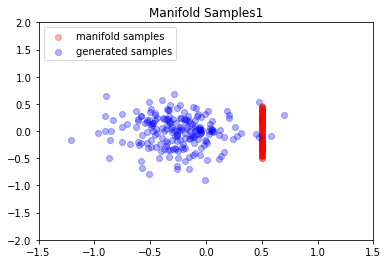

In [ ]:
import matplotlib
import os
import argparse
import torch
import torch.nn              as nn
import torch.optim           as optim
import matplotlib.pyplot     as plt
import numpy                 as np
from   mpl_toolkits.axes_grid1 import make_axes_locatable
from   torch.utils.data        import Dataset, TensorDataset, DataLoader
import time

device = "cpu" # cpu device
#-----------------------------------------------------------------
# Sampling and Batch Sizes
#-----------------------------------------------------------------
n_samples_man = 100  
n_samples     = 200  # must be a multiple of n_samples_man
batch_size    = 100
num_batches   = int(n_samples / batch_size)
#-----------------------------------------------------------------
# Manifold Data
#-----------------------------------------------------------------
u_true = torch.rand(n_samples_man, 2).to(device) - 0.5
u_true[:,0] = 0.5
u_gen       = 0.3 * torch.randn(n_samples, 2).to(device)
u_gen[:,0] -= 0.25


x_min = -1.5
x_max = 1.5
y_min = -2
y_max = 2
#-----------------------------------------------------------------
# Plot Manifold Samples
#-----------------------------------------------------------------
def plot_distributions(dist1, dist2, index):
  fig = plt.figure()
  plt.scatter(dist1[:,0],dist1[:,1], c='r', alpha=0.3)
  plt.scatter(dist2[:,0],dist2[:,1], c='b', alpha=0.3)
  plt.ylim(y_min, y_max);
  plt.xlim(x_min, x_max)
  plt.legend(['manifold samples', 'generated samples'], loc='upper left',)
  title_str = 'Manifold Samples' + str(index)
  plt.title(title_str)
  plt.show()
  plt.close(fig)
  plt.close(plt.gcf())

plot_distributions(u_true, u_gen, 1)

def get_prefix(ctr): # Prefix for saving file names
    if ctr < 10:
        return '00000'
    elif ctr < 100:
        return '0000'
    elif ctr < 1000:
        return '000'
    elif ctr < 10000:
        return '00'
    elif ctr < 100000:
        return '0'
    else:
        return ''  

filename = './image_' + get_prefix(1) + str(1) + '.csv'
with open(filename, 'w') as f: 
  f.write('a,b\n')
  for file_ctr in range(u_gen.shape[0]):     
    f.write('%0.5e,%0.5e\n' % (u_gen[file_ctr, 0], u_gen[file_ctr, 1])) 

filename = './manifold.csv'
with open(filename, 'w') as f: 
  f.write('a,b\n')
  for file_ctr in range(u_true.shape[0]):     
    f.write('%0.5e,%0.5e\n' % (u_true[file_ctr, 0], u_true[file_ctr, 1]))     

In [ ]:
class distance_estimator(nn.Module):
    def __init__(self, n_feats, n_hid_params, hidden_layers, n_projs, device, beta=0.5):
        super().__init__()        
        self.hidden_layers = hidden_layers  # number of hidden layers in the network
        self.n_projs       = n_projs        # number of projections to use for weights onto Steiffel manifold
        self.beta          = beta           # scalar in (0,1) for stabilizing feed forward operations
        
        # Intialize initial, middle, and final layers
        self.fc_one = torch.nn.Linear(n_feats, n_hid_params, bias=True )
        self.fc_mid = nn.ModuleList([torch.nn.Linear(n_hid_params, n_hid_params, bias=True ) for i in range(self.hidden_layers)])
        self.fc_fin = torch.nn.Linear(n_hid_params, 1, bias=True )

        # Normalize weights (helps ensure stability with learning rate)
        self.fc_one.weight = nn.Parameter(self.fc_one.weight/torch.norm(self.fc_one.weight))
        for i in range(self.hidden_layers):
            self.fc_mid.weight = nn.Parameter(self.fc_mid[i].weight/torch.norm(self.fc_mid[i].weight))          
        self.fc_fin.weight = nn.Parameter(self.fc_fin.weight/torch.norm(self.fc_fin.weight))
                        
    def forward(self, u):     
        u = self.fc_one(u).sort(1)[0]                             # Apply first layer affine mapping
        for i in range(self.hidden_layers):                       # Loop for each hidden layer                     
          u = u + self.beta * (self.fc_mid[i](u).sort(1)[0] - u)  # Convex combo of u and sort(W*u+b)
        return torch.abs(self.fc_fin(u))                          # Final layer is scalar (no need to sort)
    
    def project_weights(self):
        self.fc_one.weight.data = self.proj_Stiefel(self.fc_one.weight.data, self.n_projs)
        for i in range(self.hidden_layers):
            self.fc_mid[i].weight.data = self.proj_Stiefel(self.fc_mid[i].weight.data, self.n_projs)
        self.fc_fin.weight.data = self.proj_Stiefel(self.fc_fin.weight.data, self.n_projs)           
            
    def proj_Stiefel(self, Ak, proj_iters):  # Project to closest orthonormal matrix
        n = Ak.shape[1]
        I = torch.eye(n)
        for k in range(proj_iters):
            Qk = I - Ak.permute(1, 0).matmul(Ak)
            Ak = Ak.matmul(I + 0.5 * Qk)
        return Ak

In [ ]:
n_hid_params   = 10    # Parameters in each hidden layer
n_hid_layers   = 10    # Total hidden layers
n_projs        = 2     # Number of projections to Stiefel manifold
beta           = 1.0   # Relaxation parameter in network feed forward operations
n_feats        = 2     # Our signals are in R^2
netD           = distance_estimator(n_feats, n_hid_params, n_hid_layers, n_projs, device, beta=beta)
max_epochs     = int(1e7)
learning_rate  = 5.0e-4
optimizer      = optim.SGD(netD.parameters(), lr=learning_rate)
drop_freq      = 100000   # Frequency for decaying step sizes
decay_rate     = 1.0      # Step size decay proportion
prog_threshold = 1.0e-3   # Determines when to perform generator update
eta_threshold  = 0.5      # Minimum value of eta allowed to perform generator update
man_thresh     = 5.0e-2
n_steps        = 12
hist_dist      = np.zeros(n_steps)
hist_eta       = np.zeros(n_steps)
checkpt_path   = './models/'

def gamma(k): # Relaxation parameter used for Halpern updates
    return (1 + k) ** (-1) 

distance_estimator(
  (fc_one): Linear(in_features=2, out_features=10, bias=True)
  (fc_mid): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): Linear(in_features=10, out_features=10, bias=True)
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): Linear(in_features=10, out_features=10, bias=True)
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): Linear(in_features=10, out_features=10, bias=True)
  )
  (fc_fin): Linear(in_features=10, out_features=1, bias=True)
)
[1: 1000/10000000] d(uk): 3.154e-01, d(man): 1.372e-02, eta = 0.161, eta-diff = 9.908e-03, lr 5.000e-04, timer 0.01
[1: 2000/10000000] d(uk): 4.447e-01, d(man): 1.432e-02, eta = 0.261, eta-diff = 9.815e-03, lr 5.000e-04, timer

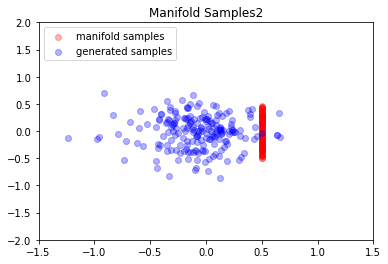

Saved Checkpoint:./models/step_000003.pth
[3: 16000/10000000] d(uk): 0.000e+00, d(man): 7.998e-03, eta = 0.925, eta-diff = 8.211e-04, lr 5.000e-04, timer 0.01


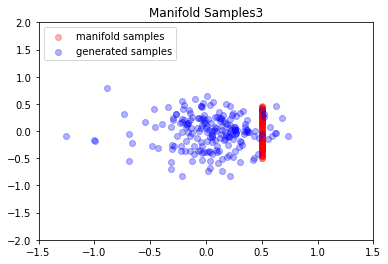

Saved Checkpoint:./models/step_000004.pth
[4: 17000/10000000] d(uk): 0.000e+00, d(man): 9.148e-03, eta = 0.923, eta-diff = 3.050e-04, lr 5.000e-04, timer 0.01


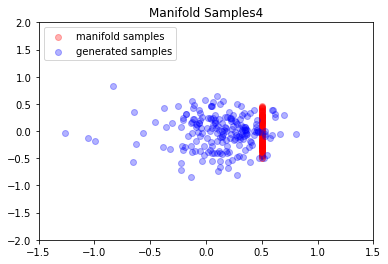

Saved Checkpoint:./models/step_000005.pth
[5: 18000/10000000] d(uk): 0.000e+00, d(man): 1.080e-02, eta = 0.922, eta-diff = 1.248e-04, lr 5.000e-04, timer 0.01


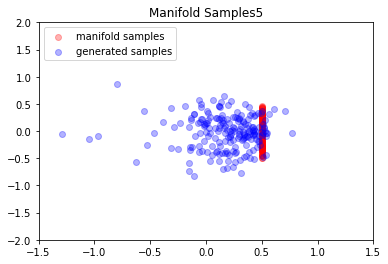

Saved Checkpoint:./models/step_000006.pth
[6: 19000/10000000] d(uk): 0.000e+00, d(man): 1.361e-02, eta = 0.926, eta-diff = 2.843e-04, lr 5.000e-04, timer 0.01


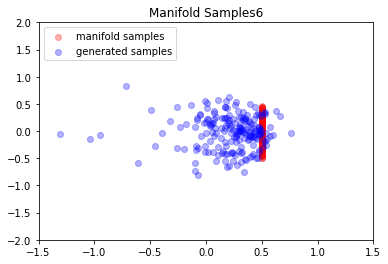

Saved Checkpoint:./models/step_000007.pth
[7: 20000/10000000] d(uk): 0.000e+00, d(man): 1.374e-02, eta = 0.929, eta-diff = 3.032e-04, lr 5.000e-04, timer 0.02


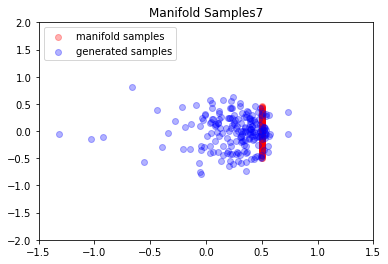

Saved Checkpoint:./models/step_000008.pth
[8: 21000/10000000] d(uk): 0.000e+00, d(man): 1.493e-02, eta = 0.930, eta-diff = 2.008e-04, lr 5.000e-04, timer 0.01


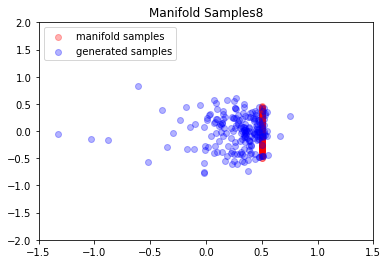

Saved Checkpoint:./models/step_000009.pth
[9: 22000/10000000] d(uk): 0.000e+00, d(man): 1.462e-02, eta = 0.930, eta-diff = 1.228e-04, lr 5.000e-04, timer 0.01


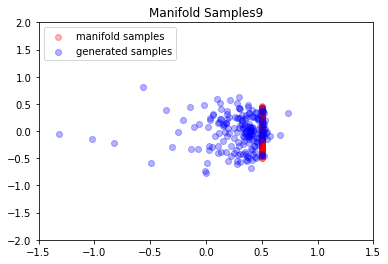

Saved Checkpoint:./models/step_000010.pth
[10: 23000/10000000] d(uk): 0.000e+00, d(man): 1.602e-02, eta = 0.940, eta-diff = 6.373e-04, lr 5.000e-04, timer 0.01


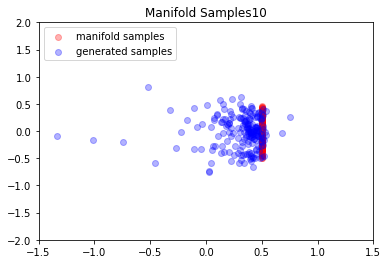

Saved Checkpoint:./models/step_000011.pth
[11: 24000/10000000] d(uk): 0.000e+00, d(man): 1.434e-02, eta = 0.943, eta-diff = 4.100e-04, lr 5.000e-04, timer 0.01


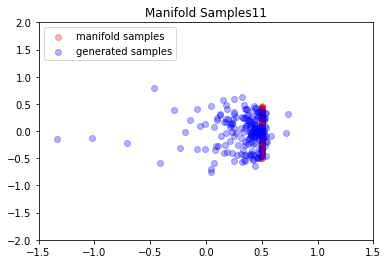

Saved Checkpoint:./models/step_000012.pth
[12: 25000/10000000] d(uk): 0.000e+00, d(man): 1.442e-02, eta = 0.945, eta-diff = 2.694e-04, lr 5.000e-04, timer 0.01


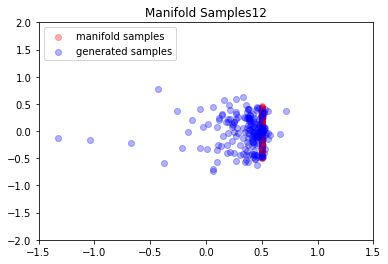

In [ ]:
#--------------------------------------
#  Initialize Training
#--------------------------------------
k        = 1  # defines the index for {u^k}
ave_diff = 0
ctr      = 1  # inner loop for solving the k-th minimization problem
eta      = 0
dist_est = 0.0
dist_man = 0.0
loss     = 0.0
eta_prev = 0.0
uk       = u_gen
u1       = u_gen

print(netD) 
#------------------------------------------------------------
# Identify if stopping criteria are met for current step
#------------------------------------------------------------
def stop_crit_met(epoch, ave_diff, eta, prog_thresh, eta_thresh, ctr, k, dist_man):    
    if epoch%1000 != 0:           # Only update once every 100 epochs
        return False
    elif ctr > 30000:
        return True
    elif eta < eta_thresh:       # Optimal eta = 1.00
        return False    
    elif ave_diff > prog_thresh: # Require estimate progress to be small (close to optimal)
        return False
    elif ave_diff == 0:          # Require their to be forward progress 
        return False    
    elif dist_man > man_thresh:
        return False
    return True
#------------------
# Training
#------------------
for epoch in range(1, max_epochs + 1):    
    if k < n_steps:
        t0        = time.time()                            
        optimizer.zero_grad()  # Initialize gradient to zero
        err_real     = torch.mean(netD(u_true))
        err_fake     = torch.mean(netD(uk+ 0.02*torch.randn(uk.shape)))
        err          = err_real - err_fake
        soft_const   = 10 * torch.mean(netD(u_true) ** 2) # tau = 1, p = 2
        loss         = err + soft_const
        dist_est     = -0.01 * err.detach() + 0.99 * dist_est            
        loss.backward()
        optimizer.step()  

        dist_man = 0.01 * err_real.detach().numpy() + 0.99 * dist_man
        netD.project_weights()
        uk.requires_grad_(True)
        Jout   = netD(uk)
        nablaJ = torch.autograd.grad(outputs=Jout, inputs=uk, # take derivative w.r.t only inputs
                                  grad_outputs=torch.ones(Jout.size()).to(device), only_inputs=True)[0]        
        
        eta      = 0.001 * (torch.norm(nablaJ, p=2, dim=1) ** 2).mean().cpu().numpy() + 0.999 * eta
        

        ctr += 1  
        if ctr%100 == 0:              
          ave_diff = 0.1 * np.maximum(0, eta - eta_prev) + 0.9 * ave_diff   
          eta_prev = eta        
           
            
      
        if stop_crit_met(epoch, ave_diff, eta, prog_threshold, eta_threshold, ctr, k, dist_man):
          #------------------------------------
          # Update distribution estimate uk
          #------------------------------------                       
          beta_k    = dist_est
          dist_est  = 0   
          uk.requires_grad_(True)
          Jout   = netD(uk)
          nablaJ = torch.autograd.grad(outputs=Jout, inputs=uk,   # Compute derivative w.r.t inputs
                                    grad_outputs=torch.ones(Jout.size()).to(device), only_inputs=True)[0]                                                   
          
          # Uncomment for different step size rules
          diag = 0.5 * beta_k            # Fixed step size based on average distance
          # diag = 0.5 * Jout              # Individualized step size
          #diag = 0.25 * (beta_k + Jout)  # Combo rule
      
          uk    = gamma(k) * u1 + (1-gamma(k)) * (uk - diag * nablaJ)  
          uk    = uk.detach()
          k    += 1 # update outer iteration number
          ctr   = 0 # Reset counter for stopping critera  
          #--------------------------
          # Save weights/step sizes
          #--------------------------
          state = {
            'epoch': epoch,
            'eta': eta,
            'learning_rate': optimizer.param_groups[0]['lr'],
            'state_dict': netD.state_dict(),
            'lambda_k': 0,
            'ave_true': err_real.detach().cpu().numpy(),
          }         
          if not os.path.exists(os.path.dirname(checkpt_path)):
              print("created path: ", checkpt_path)
              os.makedirs(os.path.dirname(checkpt_path))
          save_checkpt_str = checkpt_path + 'step_' + get_prefix(k) + str(k) + '.pth'          
          torch.save(state, save_checkpt_str) 
          print('Saved Checkpoint:' + save_checkpt_str) 
        #------------------------
        # Update drop frequency
        #------------------------
        if ctr % drop_freq == 0 and ctr > 0:
            optimizer.param_groups[0]['lr'] *= decay_rate        
        #------------------------
        # Output training stats
        #------------------------
        if epoch % 1000 == 0:
            print('[%d: %d/%d] d(uk): %.3e, d(man): %.3e, eta = %.3f, eta-diff = %0.3e, lr %.3e, timer %0.2f'
                % (k, epoch, max_epochs, dist_est, dist_man, eta, ave_diff, optimizer.param_groups[0]['lr'], time.time() - t0))
        #------------------------
        # Plot training data
        #------------------------
        if ctr == 0:
            plot_distributions(u_true.detach(), uk.detach(), k)   
            # -----------------------------------
            # -----------------------------------
            # Save u_gen and distance plot
            # -----------------------------------
            # ----------------------------------- 
            filename = './image_' + get_prefix(k) + str(k) + '.csv'
            with open(filename, 'w') as f: 
              f.write('a,b\n')
              for file_ctr in range(uk.shape[0]):     
                f.write('%0.5e,%0.5e\n' % (uk[file_ctr, 0], uk[file_ctr, 1]))       

        # ------------------------
        # Evaluate J on 2D grid
        # ------------------------        
        if ctr % 1000 == 0:
            fig = plt.figure()
            a = torch.linspace(x_min, x_max, 200)
            b = torch.linspace(y_max, y_min, 200)
            gridPts   = torch.stack(torch.meshgrid(a, b)).to(device)
            gridShape = gridPts.shape[1:]
            gridPts   = gridPts.reshape(2, -1).t()
            disc_grid = netD(gridPts)
            disc_grid = disc_grid.detach().cpu()
            
            plt.imshow(disc_grid.reshape(gridShape).t())
            #plt.clim(0,2.5)
            plt.colorbar()
            J_title_str = 'Manifold Distance Function Landscape:' + str(k)
            fig.savefig('distance_landscape_' + get_prefix(epoch+1) + str(epoch+1) + '.png')
            
            plt.title(J_title_str)
            plt.close(fig)
            plt.close(plt.gcf())

In [ ]:
filename = './image_' + get_prefix(k) + str(k) + '.csv'
with open(filename, 'w') as f: 
  f.write('a,b\n')
  for file_ctr in range(uk.shape[0]):     
    f.write('%0.5e,%0.5e\n' % (uk[file_ctr, 0], uk[file_ctr, 1])) 